In [2]:
import cv2
from PIL import Image, ImageDraw, ImageFont
import pyrealsense2 as rs
import numpy as np
from vision.classification_model import ClassificationModel
from vision.segmentation_model import SegmentationModel
# from vision.vision_models import SegmentationModel, ClassificationModel
import keras
import matplotlib.pyplot as plt

In [3]:
IMG_SIZE = "img_size"
BATCH_SIZE = "batch_size"
OPTIMIZER = "optimizer"
EPOCHS = "epochs"
LOSS = "loss"
METRICS = "metrics"
LEARNING_RATE = "learning_rate"
PATIENCE = "patience"
CALLBACKS = "callbacks"
PATH = "path"

## TODO:

- Combine into pipeline
- Figure out how to access crops without saving
- Update Classification output
- Test camera depth 

# Segmentation Model

This model is responsible for extracting crate front segments out of the picture of the entire carrier. These crops are then saved and forwarded to the classification model, as well as used for the pickup-point calculation.

In [ ]:
segment_model = SegmentationModel()

In [ ]:
seg_params = {
    PATH: "data/no-bars_no-classes",
    IMG_SIZE: 640,
    OPTIMIZER: "AdamW",
    LEARNING_RATE: 0.0015,
    EPOCHS: 80,
    BATCH_SIZE: 8,
    PATIENCE: 10
}

In [ ]:
#load previously trained model
segment_model.load_model()

In [ ]:
#train model
segment_model.train(seg_params)

In [ ]:
#evaluate model
segment_model.test()

In [ ]:
#try model out on image(s)
results = segment_model.predict(seg_params[PATH]+"/test/images")

# Classification Model
This model is used to take cropped images of crate fronts and classify them by their pickup method. These classifications will then be combined to determine pickup point

In [17]:
class_model = ClassificationModel()

In [ ]:
learning_rate = 0.001
weight_decay = 0.004
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
params = {
    IMG_SIZE: (640,640),
    BATCH_SIZE: 16,
    OPTIMIZER: keras.optimizers.AdamW(learning_rate,weight_decay),
    LOSS: keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    METRICS: ["accuracy"],
    EPOCHS: 20,
    CALLBACKS: [callback]
}

In [ ]:
#load previous model
class_model.load_model()

In [ ]:
#train model
class_model.train(params, show=True)

In [ ]:
#evaluate model
class_model.test()

In [ ]:
#test model on new image
class_model.predict(1) #TODO: update

# Camera Integration

# Complete Pipeline

### Connect to camera

### Load models

In [4]:
from keras import backend as K

K.clear_session()

In [5]:
sm = SegmentationModel()
sm.load_model()

In [29]:
cm = ClassificationModel()
cm.load_model()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 640, 640, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 640, 640, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 640, 640, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 320, 320, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 320, 320, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 160, 160, 32)      0         
 g2D)                                                

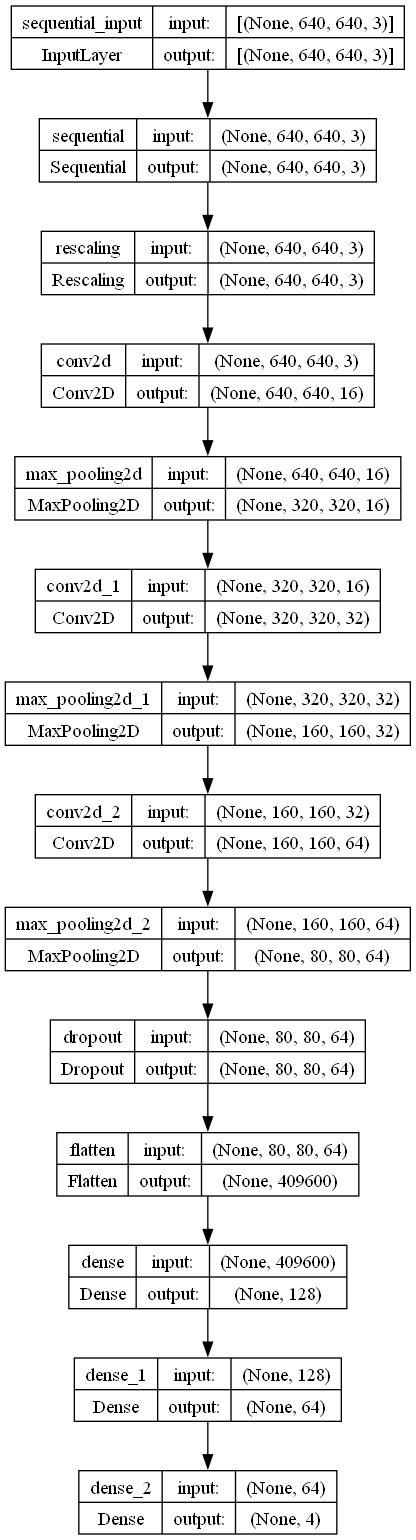

In [6]:
keras.utils.plot_model(cm.model,
                       "model.png",
                       show_shapes=True)

### Combine stream

In [6]:
project_path = "vision/crops/monkey"

In [18]:
results = sm.predict("vision/test_frame.jpg", True, True)


image 1/1 c:\Users\simon\OneDrive\Schule\2023_WS\THUAS\colruyt\colruyt-destack\vision\test_frame.jpg: 384x640 2 Crates, 246.1ms
Speed: 16.1ms preprocess, 246.1ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to vision\crops\monkey2


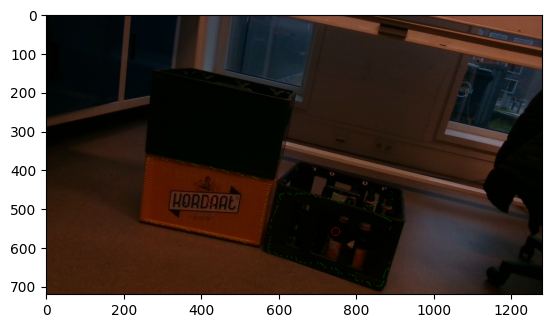

In [57]:
# calculate segmentation outline + center
input_img = Image.open("vision/test_frame.jpg")
draw = ImageDraw.Draw(input_img)
radius = 10
pix = input_img.load()
boxes = results[0].boxes.xyxy.tolist()
classes = results[0].boxes.cls.tolist()
names = results[0].names
confidences = results[0].boxes.conf.tolist()
masks = results[0].masks

# Iterate through each detected object's box, class, confidence, and mask
for box, cls, conf, mask in zip(boxes, classes, confidences, masks):
    mean_x,mean_y = np.mean(mask.xy[0],axis=0)
    for x,y in mask.xy[0]:
        pix[x,y] = (0, 255, 0)
    
    draw.ellipse((mean_x - radius,mean_y - radius, mean_x + radius, mean_y + radius), outline = (255,0, 0))
    pix[mean_x, mean_y] = (255,0,0)

plt.imshow(input_img)

In [8]:
classes, conf = cm.predict(project_path+"/crops/Crate")

1/1 [==============================] - 0s 36ms/step


In [45]:
# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()

config.enable_stream(rs.stream.depth)
config.enable_stream(rs.stream.color)

# Start streaming
pipeline.start(config)
sensor = pipeline.get_active_profile().get_device().query_sensors()[1]

# Set the exposure anytime during the operation
sensor.set_option(rs.option.exposure, 500.000)

try:
    while True:

        # Wait for a coherent pair of frames: depth and color
        frames = pipeline.wait_for_frames()
        depth_frame = frames.get_depth_frame()
        color_frame = frames.get_color_frame()
        if not depth_frame or not color_frame:
            continue

        color_image = np.asanyarray(color_frame.get_data())
        depth_image = np.asanyarray(depth_frame.get_data())
        
        results = sm.predict(color_image,False,True)
        classes, conf_list = cm.predict("vision/crops/monkey3/crops/Crate")
        data_image = Image.open("vision/crops/monkey3/image0.jpg")
        masks = results[0].masks
        c0 = Image.fromarray(color_image)
        c1 = ImageDraw.Draw(data_image)
        font = ImageFont.truetype("vision/data/Arial.ttf", 40)

        for mask, label in zip(masks,classes):
            mean_x,mean_y = np.mean(mask.xy[0],axis=0)
            mean_x = int(mean_x)
            mean_y = int(mean_y)
            depth_rs = (depth_frame.get_distance(mean_x, mean_y)*100)
            print(f"Depth Size: {depth_image.shape}, Color Size: {color_image.shape}")
            print(f"Depth: {round(depth_rs,2)}cm")
            c1.text((mean_x,mean_y), f"{label}, {round(depth_rs,2)}cm", fill=(0,255,0), font=font)
        data_image.show()
        data_image.save("distance_annot.jpg")
        break
        
except Exception as e:
    print(e)
    pass


0: 384x640 2 Crates, 196.6ms
Speed: 0.0ms preprocess, 196.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to vision\crops\monkey3
1/1 [==============================] - 0s 54ms/step
Depth Size: (720, 1280), Color Size: (720, 1280, 3)
Depth: 109.1cm
Depth Size: (720, 1280), Color Size: (720, 1280, 3)
Depth: 112.4cm


In [1]:
#show both vision streams
%%script false --no-raise-error
# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()

config.enable_stream(rs.stream.depth)
config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)

# Start streaming
pipeline.start(config)

try:
    while True:

        # Wait for a coherent pair of frames: depth and color
        frames = pipeline.wait_for_frames()
        depth_frame = frames.get_depth_frame()
        color_frame = frames.get_color_frame()
        if not depth_frame or not color_frame:
            continue

        # Convert images to numpy arrays
        depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())

        # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

        depth_colormap_dim = depth_colormap.shape
        color_colormap_dim = color_image.shape

        # If depth and color resolutions are different, resize color image to match depth image for display
        if depth_colormap_dim != color_colormap_dim:
            resized_color_image = cv2.resize(color_image, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
            images = np.hstack((resized_color_image, depth_colormap))
        else:
            images = np.hstack((color_image, depth_colormap))
        
        # Show images
        cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
        cv2.imshow('RealSense', images)
        cv2.waitKey(1)

finally:

    # Stop streaming
    pipeline.stop()

UsageError: Line magic function `%%script` not found.
